In [1]:
import os
from PIL import Image
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor, to_pil_image
from IPython.display import display

from clip.simple_tokenizer import SimpleTokenizer
from utils.initialize_font_data import font_dir, fox_text_four_lines, train_json_path, exclusive_attributes, gray_scale_image_file_dir
from utils.init_model import model, preprocess, my_preprocess, device, convert_weights, model_name, _download, _MODELS, load
from dataset.dataset import MyDataset, set_image_tensors
from utils.coop_model import CoOpCLIP

tokenizer = SimpleTokenizer()

exclusive_attributes:  []
loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


In [2]:
dataset = MyDataset(
  font_dir, 
  train_json_path, 
  [fox_text_four_lines], 
  char_size=150,
  attribute_threshold=50,
  use_negative=True,
  preprocess=my_preprocess, 
  use_multiple_attributes=True, 
  use_random_attributes=True, 
  max_sample_num=3, 
  random_prompts_num=10,
  exclusive_attributes=exclusive_attributes,
  image_file_dir=gray_scale_image_file_dir,
  dump_image=True,
)
set_image_tensors(dataset, sample_num=5)
data_loader = DataLoader(dataset, batch_size=4, shuffle=False)

100%|██████████| 120/120 [00:00<00:00, 1002.68it/s]


load image tensors from image files ...


100%|██████████| 120/120 [00:00<00:00, 258.15it/s]


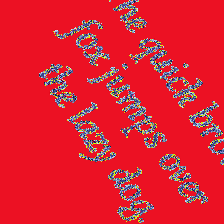

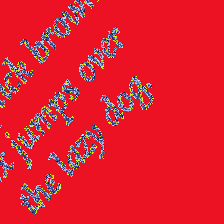

<|startoftext|>not strong , pretentious font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [3]:
for batch in iter(data_loader):
  images, texts = batch
  int_text = [int(token) for token in texts[0]]
  decoded_text = tokenizer.decode(int_text)
  display(to_pil_image(images[0]))
  display(to_pil_image(images[1]))
  print(decoded_text)
  break

In [4]:
vpt_applied_layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
precontext_vision_length = 10
precontext_dropout_rate = 0.0
print(model.visual.transformer.resblocks[1].mlp.c_fc.weight[0][0])
coop_model = CoOpCLIP(
  model,
  device=device, 
  vision_coop=True,
  precontext_vision_length=precontext_vision_length,
  precontext_dropout_rate=precontext_dropout_rate,
  vpt_applied_layers=vpt_applied_layers,
)
clip_model, _ = load(model_name, jit=False, device=device)
# copy the parameters of clip_model.visual to coop_model.visual
coop_model.visual.load_state_dict(clip_model.visual.state_dict(), strict=False) # strict=True to ignore missing keys, such as precontext_vision
convert_weights(coop_model)
print(type(coop_model))
print(coop_model.transformer.resblocks[1].mlp.c_fc.weight[0][0])
print(coop_model.visual.transformer.resblocks[1].mlp.c_fc.weight[0][0])
print(coop_model.visual.precontext_vision0[0][0][0])
print(coop_model.visual.precontext_vision1[0][0][0])
print(coop_model.visual.precontext_vision11[0][0][0])

tensor(0.0029, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)


loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt
<class 'utils.coop_model.CoOpCLIP'>
tensor(-0.0153, device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
tensor(0.0029, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)
tensor(-0.5684, device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
tensor(0.6128, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)
tensor(1.0059, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)


In [5]:
for name, param in coop_model.named_parameters():
    if name.startswith("visual.precontext_vision"):
        print(name)
        param.requires_grad = True
    else:
        param.requires_grad = False

visual.precontext_vision0
visual.precontext_vision1
visual.precontext_vision2
visual.precontext_vision3
visual.precontext_vision4
visual.precontext_vision5
visual.precontext_vision6
visual.precontext_vision7
visual.precontext_vision8
visual.precontext_vision9
visual.precontext_vision10
visual.precontext_vision11


In [6]:
coop_optimizer = optim.Adam(
    coop_model.coop_parameters(),
    lr=1e-3,
    betas=(0.9, 0.98),
    eps=1e-6,
    weight_decay=0.2,
)

In [19]:
coop_model.train()
coop_optimizer.zero_grad()
images, texts = next(iter(data_loader))
print(images.dtype)
images = images.to(device)
texts = texts.to(device)

# input
image_features = coop_model.encode_image(images)
text_features = coop_model.encode_text(texts)
image_features = image_features / image_features.norm(
    dim=-1, keepdim=True
)
text_features = text_features / text_features.norm(
    dim=-1, keepdim=True
)
logit_scale = coop_model.logit_scale.exp()
logits_per_image = (
    logit_scale * image_features @ text_features.t()
)
logits_per_text = logits_per_image.t()
ground_truth = torch.arange(
    len(images), dtype=torch.long, device=device
)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
total_loss = (
    loss_img(logits_per_image, ground_truth)
    + loss_txt(logits_per_text, ground_truth)
) / 2
total_loss.backward()
coop_optimizer.step()
print(coop_model.transformer.resblocks[1].mlp.c_fc.weight[0][0])
print(coop_model.visual.transformer.resblocks[1].mlp.c_fc.weight[0][0])
print(coop_model.visual.precontext_vision0[0][0][0])
print(coop_model.visual.precontext_vision1[0][0][0])
print(coop_model.visual.precontext_vision11[0][0][0])

torch.float16
tensor(-0.0153, device='cuda:0', dtype=torch.float16)
tensor(0.0029, device='cuda:0', dtype=torch.float16)
tensor(-0.5576, device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
tensor(0.6021, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)
tensor(0.9951, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)


In [8]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

In [9]:
print(coop_model.visual.precontext_vision0.dtype)
convert_models_to_fp32(coop_model)
print(coop_model.visual.precontext_vision0.dtype)
convert_weights(coop_model)
print(coop_model.visual.precontext_vision0.dtype)

torch.float16
torch.float16
torch.float16
